## Utils

In [1]:
from tests.test_tools_common import output_dir


# @title Parsing JSON output
def parse_json(json_output: str):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i + 1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [2]:
# @title Plotting Util

import json
import io
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]


def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        im: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
                 'red',
                 'green',
                 'blue',
                 'yellow',
                 'orange',
                 'pink',
                 'purple',
                 'brown',
                 'gray',
                 'beige',
                 'turquoise',
                 'cyan',
                 'magenta',
                 'lime',
                 'navy',
                 'maroon',
                 'teal',
                 'olive',
                 'coral',
                 'lavender',
                 'violet',
                 'gold',
                 'silver',
             ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("assets/2d_spatial_understanding/NotoSansSC-Regular.ttf", size=14)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json.loads(bounding_boxes)):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_y1 = int(bounding_box["box_2d"][0] / 1000 * height)
        abs_x1 = int(bounding_box["box_2d"][1] / 1000 * width)
        abs_y2 = int(bounding_box["box_2d"][2] / 1000 * height)
        abs_x2 = int(bounding_box["box_2d"][3] / 1000 * width)

        if abs_x1 > abs_x2:
            abs_x1, abs_x2 = abs_x2, abs_x1

        if abs_y1 > abs_y2:
            abs_y1, abs_y2 = abs_y2, abs_y1

        # Draw the bounding box
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        # Draw the text
        if "label" in bounding_box:
            draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    img.show()

In [3]:
import json
from typing import Tuple
# @title Segmentation Utils

import dataclasses
import numpy as np
import base64


@dataclasses.dataclass(frozen=True)
class SegmentationMask:
    # bounding box pixel coordinates (not normalized)
    y0: int  # in [0..height - 1]
    x0: int  # in [0..width - 1]
    y1: int  # in [0..height - 1]
    x1: int  # in [0..width - 1]
    mask: np.array  # [img_height, img_width] with values 0..255
    label: str


def parse_segmentation_masks(
        predicted_str: str, *, img_height: int, img_width: int
) -> list[SegmentationMask]:
    items = json.loads(parse_json(predicted_str))
    masks = []
    for item in items:
        raw_box = item["box_2d"]
        abs_y0 = int(item["box_2d"][0] / 1000 * img_height)
        abs_x0 = int(item["box_2d"][1] / 1000 * img_width)
        abs_y1 = int(item["box_2d"][2] / 1000 * img_height)
        abs_x1 = int(item["box_2d"][3] / 1000 * img_width)
        if abs_y0 >= abs_y1 or abs_x0 >= abs_x1:
            print("Invalid bounding box", item["box_2d"])
            continue
        label = item["label"]
        png_str = item["mask"]
        if not png_str.startswith("data:image/png;base64,"):
            print("Invalid mask")
            continue
        png_str = png_str.removeprefix("data:image/png;base64,")
        png_str = base64.b64decode(png_str)
        mask = Image.open(io.BytesIO(png_str))
        bbox_height = abs_y1 - abs_y0
        bbox_width = abs_x1 - abs_x0
        if bbox_height < 1 or bbox_width < 1:
            print("Invalid bounding box")
            continue
        mask = mask.resize((bbox_width, bbox_height), resample=Image.Resampling.BILINEAR)
        np_mask = np.zeros((img_height, img_width), dtype=np.uint8)
        np_mask[abs_y0:abs_y1, abs_x0:abs_x1] = mask
        masks.append(SegmentationMask(abs_y0, abs_x0, abs_y1, abs_x1, np_mask, label))
    return masks


def overlay_mask_on_img(
        img: Image,
        mask: np.ndarray,
        color: str,
        alpha: float = 0.7
) -> Image.Image:
    """
    Overlays a single mask onto a PIL Image using a named color.

    The mask image defines the area to be colored. Non-zero pixels in the
    mask image are considered part of the area to overlay.

    Args:
        img: The base PIL Image object.
        mask: A PIL Image object representing the mask.
              Should have the same height and width as the img.
              Modes '1' (binary) or 'L' (grayscale) are typical, where
              non-zero pixels indicate the masked area.
        color: A standard color name string (e.g., 'red', 'blue', 'yellow').
        alpha: The alpha transparency level for the overlay (0.0 fully
               transparent, 1.0 fully opaque). Default is 0.7 (70%).

    Returns:
        A new PIL Image object (in RGBA mode) with the mask overlaid.

    Raises:
        ValueError: If color name is invalid, mask dimensions mismatch img
                    dimensions, or alpha is outside the 0.0-1.0 range.
    """
    if not (0.0 <= alpha <= 1.0):
        raise ValueError("Alpha must be between 0.0 and 1.0")

    # Convert the color name string to an RGB tuple
    try:
        color_rgb: Tuple[int, int, int] = ImageColor.getrgb(color)
    except ValueError as e:
        # Re-raise with a more informative message if color name is invalid
        raise ValueError(
            f"Invalid color name '{color}'. Supported names are typically HTML/CSS color names. Error: {e}")

    # Prepare the base image for alpha compositing
    img_rgba = img.convert("RGBA")
    width, height = img_rgba.size

    # Create the colored overlay layer
    # Calculate the RGBA tuple for the overlay color
    alpha_int = int(alpha * 255)
    overlay_color_rgba = color_rgb + (alpha_int,)

    # Create an RGBA layer (all zeros = transparent black)
    colored_mask_layer_np = np.zeros((height, width, 4), dtype=np.uint8)

    # Mask has values between 0 and 255, threshold at 127 to get binary mask.
    mask_np_logical = mask > 127

    # Apply the overlay color RGBA tuple where the mask is True
    colored_mask_layer_np[mask_np_logical] = overlay_color_rgba

    # Convert the NumPy layer back to a PIL Image
    colored_mask_layer_pil = Image.fromarray(colored_mask_layer_np, 'RGBA')

    # Composite the colored mask layer onto the base image
    result_img = Image.alpha_composite(img_rgba, colored_mask_layer_pil)

    return result_img


def plot_segmentation_masks(img: Image, segmentation_masks: list[SegmentationMask]):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img: The PIL.Image.
        segmentation_masks: A string encoding as JSON a list of segmentation masks containing the name of the object,
         their positions in normalized [y1 x1 y2 x2] format, and the png encoded segmentation mask.
    """
    # Define a list of colors
    colors = [
                 'red',
                 'green',
                 'blue',
                 'yellow',
                 'orange',
                 'pink',
                 'purple',
                 'brown',
                 'gray',
                 'beige',
                 'turquoise',
                 'cyan',
                 'magenta',
                 'lime',
                 'navy',
                 'maroon',
                 'teal',
                 'olive',
                 'coral',
                 'lavender',
                 'violet',
                 'gold',
                 'silver',
             ] + additional_colors
    font = ImageFont.truetype("assets/2d_spatial_understanding/NotoSansSC-Regular.ttf", size=14)

    # Do this in 3 passes to make sure the boxes and text are always visible.

    # Overlay the mask
    for i, mask in enumerate(segmentation_masks):
        color = colors[i % len(colors)]
        img = overlay_mask_on_img(img, mask.mask, color)

    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Draw the bounding boxes
    for i, mask in enumerate(segmentation_masks):
        color = colors[i % len(colors)]
        draw.rectangle(
            ((mask.x0, mask.y0), (mask.x1, mask.y1)), outline=color, width=4
        )

    # Draw the text labels
    for i, mask in enumerate(segmentation_masks):
        color = colors[i % len(colors)]
        if mask.label != "":
            draw.text((mask.x0 + 8, mask.y0 - 20), mask.label, fill=color, font=font)
    return img

## Launch

In [4]:
import os

import dotenv
from google import genai
from google.genai import types

dotenv.load_dotenv()

GOOGLE_API_KEY = os.getenv("GEMINI_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

```json
[
  {"box_2d": [555, 218, 735, 373], "mask": "", "label": "small piles of debris"},
  {"box_2d": [430, 573, 541, 675], "mask": "", "label": "undamaged houses"},
  {"box_2d": [341, 767, 550, 899], "mask": "", "label": "undamaged houses"},
  {"box_2d": [450, 489, 530, 497], "mask": "", "label": "upright telephone poles"},
  {"box_2d": [314, 240, 550, 378], "mask": "", "label": "undamaged houses"},
  {"box_2d": [444, 375, 514, 419], "mask": "", "label": "undamaged houses"},
  {"box_2d": [430, 462, 535, 470], "mask": "", "label": "upright telephone poles"},
  {"box_2d": [400, 80, 558, 123], "mask": "", "label": "tree"},
  {"box_2d": [394, 414, 553, 461], "mask": "", "label": "tree"},
  {"box_2d": [450, 555, 544, 565], "mask": "", "label": "upright telephone poles"},
  {"box_2d": [375, 521, 547, 577], "mask": "", "label": "tree"},
  {"box_2d": [408, 893, 550, 906], "mask": "", "label": "upright telephone poles"},
  {"box_2d": [514, 31, 858, 761], "mask": "", "label": "dirt roads"},

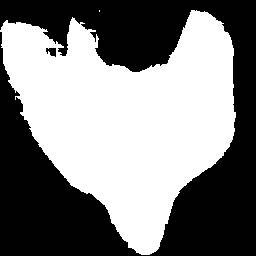
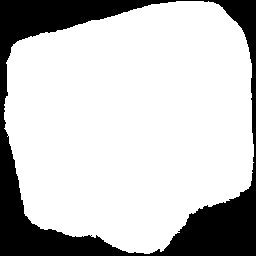
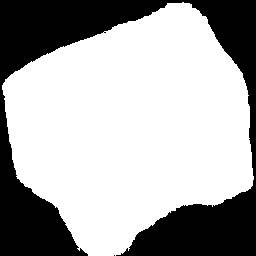
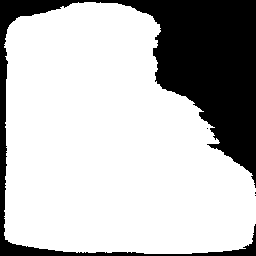
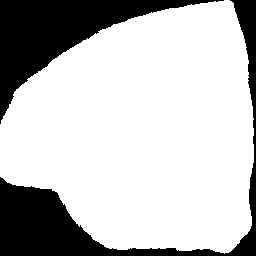
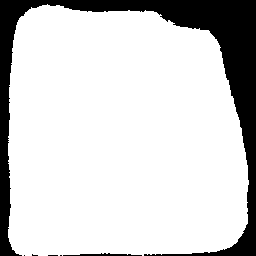
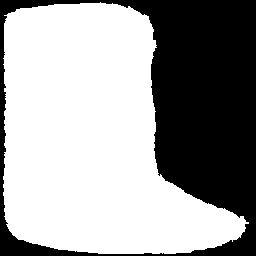
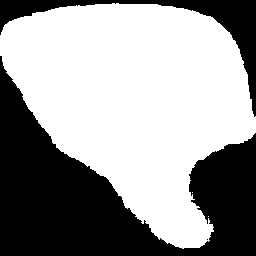
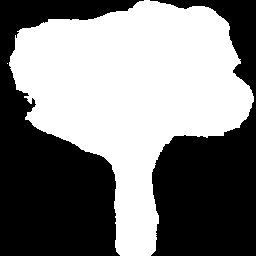
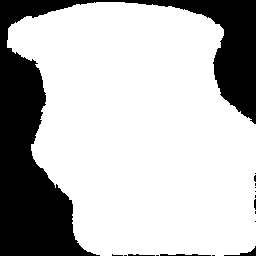
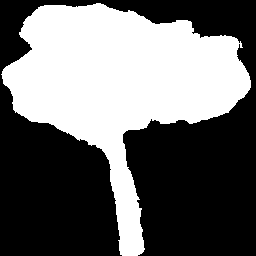
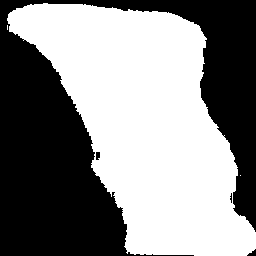
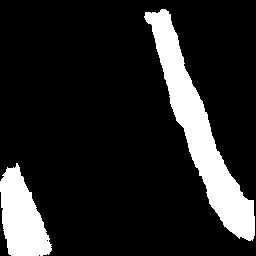
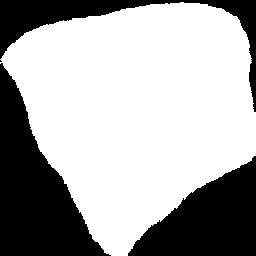
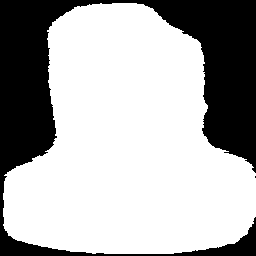
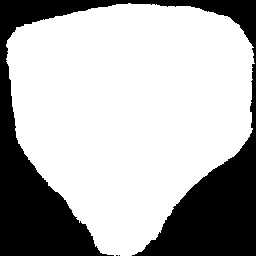
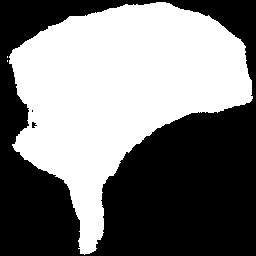
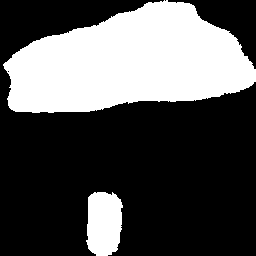
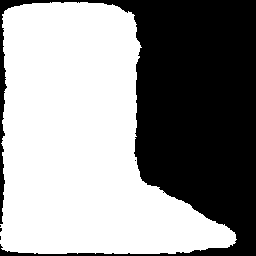
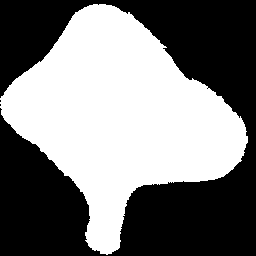
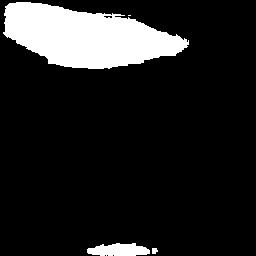
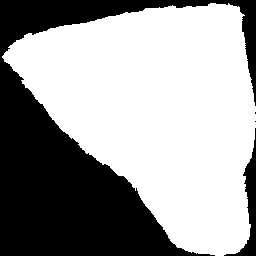
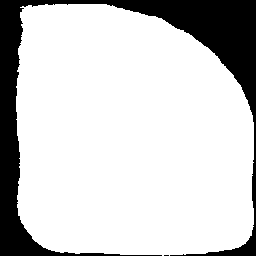
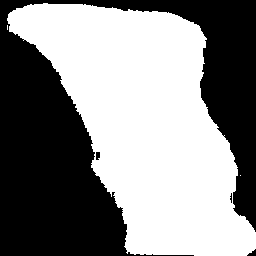

In [6]:
from io import BytesIO
from google.genai.types import ThinkingConfig
from pathlib import Path


output_dir = Path("assets/2d_spatial_understanding")

image = output_dir.joinpath("gis_guess.jpg")
prompt = """
Give the segmentation masks for the following objects:
- small piles of debris
- dirt roads
- upright telephone poles
- trees
- undamaged houses

Output a JSON list of segmentation masks where each entry contains the 2D bounding box in the key \"box_2d\", the segmentation mask in key \"mask\", and the text label in the key \"label\". Use descriptive labels.
"""  # @param {type:"string"}

# Load and resize image
im = Image.open(BytesIO(open(image, "rb").read()))
im.thumbnail([1024, 1024], Image.Resampling.LANCZOS)

# Run model to find segmentation masks
response = client.models.generate_content(
    model="gemini-2.5-pro-exp-03-25",
    contents=[prompt, im],
    config=types.GenerateContentConfig(
        temperature=0.5,
        thinking_config=ThinkingConfig(
            thinking_budget=8192
        )
    )
)

# Check output
print(response.text)

In [7]:
segmentation_masks = parse_segmentation_masks(response.text, img_height=im.size[1], img_width=im.size[0])

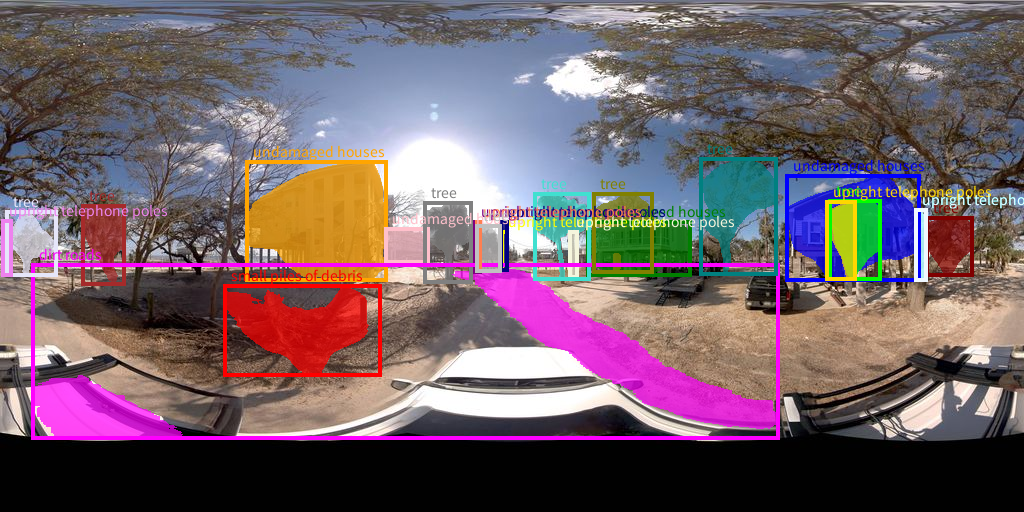

In [8]:
plot_segmentation_masks(im, segmentation_masks)